In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from time import sleep
import sys

import random

from sklearn.metrics import confusion_matrix
import seaborn as sns
# import sklearn.metrics as metrics

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# RGB data

In [4]:
from torchvision import transforms
from PIL import Image
import glob

In [ ]:
#%%time
#images = glob.glob('/content/gdrive/MyDrive/Colab Notebooks/UTKFace/*jpg')

# legend
ETHNICITIES:<br>
0: "White"<br>
1: "Black"<br>
2: "Asian"<br>
3: "Indian<br>
4: "Other"

GENDERS:<br>
0: "Male"<br>
1: "Female"

In [5]:
#random.shuffle(images)
#np.save('/content/gdrive/MyDrive/Colab Notebooks/im_names.npy', images)
images = np.load('/content/gdrive/MyDrive/Colab Notebooks/im_names.npy')

In [6]:
print(len(images))

23700


In [7]:
#@title ims_to_data
def ims_to_data(images, dims, res=True):
  transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
  data_raw = []
  n = len(images)
  #age = []
  #gender = []
  #ethnicity = []
  y = []
  for i, item in enumerate(images):
    tempo = item.split('/')[-1].split('_')
    #age.append(int(tempo[0]))
    #gender.append(int(tempo[1]))
    #ethnicity.append(int(tempo[2]))
    y.append(torch.Tensor([int(tempo[0]), int(tempo[1]), int(tempo[2])]))
    img = Image.open(item)
    if res:
      img = img.resize((dims, dims), Image.ANTIALIAS)

    img = transform(img)
    data_raw.append(img)

    sys.stdout.write('\r%d%%, item %d' % ((100*(i+1)/n),(i+1)))
    sys.stdout.flush()

  #data = torch.stack(data_raw)
  #return data, torch.Tensor(age), torch.Tensor(gender), torch.Tensor(ethnicity)
  return torch.stack(data_raw), torch.stack(y)

In [9]:
%%time
data, y = ims_to_data(images, 128, res=False)

100%, item 23700CPU times: user 3min 2s, sys: 39.2 s, total: 3min 42s
Wall time: 2h 13min


In [10]:
data_size = data.size()
print(data_size)
print(y.size())
# y - age, gender, ethnicity

torch.Size([23700, 3, 200, 200])
torch.Size([23700, 3])


In [11]:
dims = data_size[-1]

# Split data

In [12]:
batch_n = data.size(0) / 256
split_1 = int(0.75 * batch_n) * 256
split_2 = int(0.9 * batch_n) * 256  

In [13]:
X_train = data[:split_1].float()
X_val = data[split_1:split_2].float()
X_test = data[split_2:].float()

y_train = y[:split_1]
y_val = y[split_1:split_2]
y_test = y[split_2:]

In [14]:
train_size = X_train.size()
val_size = X_val.size()
test_size = X_test.size()
print(train_size)
print(val_size)
print(test_size)

torch.Size([17664, 3, 200, 200])
torch.Size([3584, 3, 200, 200])
torch.Size([2452, 3, 200, 200])


# Data distribution

age


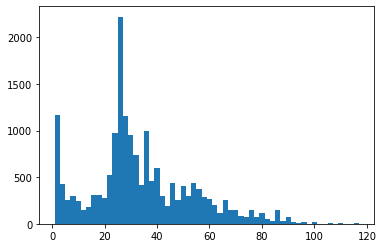

In [125]:
#data_hist = y_train[:,0]
print('age')
plt.hist(y_train[:,0], bins=np.arange(min(y_train[:,0]), max(y_train[:,0]) + 2, 2))
#plt.hist(data_hist, bins=25)
plt.show()

In [131]:
age_keys, age_ratio = torch.unique(y_train[:,0], return_counts=True)
age_keys = age_keys.numpy().astype(int)
age_ratio = (age_ratio / max(age_ratio)).numpy()
age_ratio = (np.log(np.floor(age_ratio**(-1))) * 2).astype(int)
age_ratio

array([ 1,  2,  3,  3,  4,  5,  5,  4,  5,  5,  6,  5,  6,  5,  4,  4,  5,
        4,  6,  3,  3,  3,  3,  1,  1,  0,  2,  1,  2,  2,  3,  2,  5,  3,
        1,  2,  3,  3,  4,  2,  5,  4,  5,  6,  3,  5,  5,  5,  5,  3,  5,
        4,  4,  3,  4,  4,  6,  4,  6,  3,  5,  5,  6,  7,  4,  6,  6,  6,
        7,  5,  8,  6,  7,  8,  5,  7,  8,  6,  8,  5,  8,  8,  9,  9,  5,
        8, 11,  8,  8,  6, 13,  9, 11, 10,  9, 10, 10, 13, 14, 12, 12, 14,
       13, 12])

In [132]:
age_ratio = {age_keys[i]: age_ratio[i] for i in range(age_ratio.shape[0])}

gender


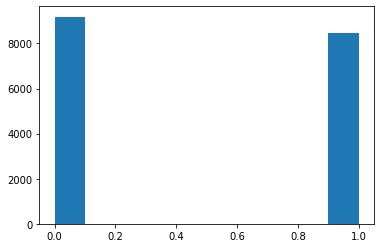

In [126]:
print('gender')
plt.hist(y_train[:,1])
plt.show()

ethnicity


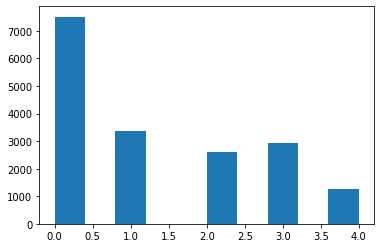

In [127]:
print('ethnicity')
plt.hist(y_train[:,2])
plt.show()

In [124]:
eth_ratio = torch.unique(y_train[:,2], return_counts=True)[1]
eth_ratio = (eth_ratio / max(eth_ratio)).numpy()
eth_ratio = (np.log(np.ceil(eth_ratio**(-1))) * 2).astype(int)
eth_ratio

array([0, 2, 2, 2, 3])

# Plot functions for loss and accuracy

In [18]:
def plot_train_val(loss_train, loss_val, mode):
  if mode=='none':
    plt.plot(np.asarray(loss_train)[:,0], label='age')
    plt.plot(np.asarray(loss_val)[:,0], label='val')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.legend()
    plt.show()
    plt.plot(np.asarray(loss_train)[:,1], label='gen')
    plt.plot(np.asarray(loss_val)[:,1], label='val')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.legend()
    plt.show()
    plt.plot(np.asarray(loss_train)[:,2], label='eth')
    plt.plot(np.asarray(loss_val)[:,2], label='val')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.legend()
    plt.show()
  else:
    if mode=='age':
      message = 'age loss'
    elif mode=='gen':
      message = 'gender loss'
    else:
      message = 'ethnicity loss'
    print(message)
    plt.plot(np.asarray(loss_train), label='train')
    plt.plot(np.asarray(loss_val), label='val')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.legend()
    plt.show()

In [19]:
def class_accuracy(model, X_in, y_in, batch_size, mode):
  model.eval()
  with torch.no_grad():
    new_size = y_in.size(0) - (y_in.size(0) % batch_size)
    acc_tempo = []
    age = []
    for i in range(0, new_size, batch_size):
      X = X_in[i:i+batch_size]
      y = y_in[i:i+batch_size]
      X = X.to(device)
      y = y.to(device)
      output = model(X)
        
      if mode=='age':
        age.extend(output.cpu())
      elif mode=='gen':
        pred = torch.argmax(output, dim=1).cpu().numpy()
        acc_tempo.append((pred==y[:,1].cpu().numpy()).mean())
      elif mode=='eth':
        pred = torch.argmax(output, dim=1).cpu().numpy()
        acc_tempo.append((pred==y[:,2].cpu().numpy()).mean())
      else:
        age.extend(output[:,0].cpu())
        pred_g = torch.argmax(output[:,1:3], dim=1).cpu().numpy()
        pred_e = torch.argmax(output[:,3:], dim=1).cpu().numpy()
        acc_tempo.append([(pred_g==y[:,1].cpu().numpy()).mean(), 
                          (pred_e==y[:,2].cpu().numpy()).mean()])

  if mode!='age':
    acc = np.mean(np.asarray(acc_tempo), axis=0) 

  if mode=='age':
    plt.scatter(y_in[:new_size,0], age)
    plt.xlabel('real', fontsize=20)
    plt.ylabel('predicted', fontsize=20)
    plt.show()
    print('age Mean Error is', torch.mean(torch.abs(y_in[:new_size,0] - torch.tensor(age))).item())
  elif mode=='gen':
    print('gender accuracy is', acc)
  elif mode=='eth':
    print('ethnicity accuracy is', acc)
  else:
    plt.scatter(y_in[:new_size,0], age)
    plt.xlabel('real', fontsize=20)
    plt.ylabel('predicted', fontsize=20)
    plt.show()
    print('age Mean Error is', torch.mean(torch.abs(y_in[:new_size,0] - torch.tensor(age))).item())
    print('gender accuracy is', acc[0])
    print('ethnicity accuracy is', acc[1])

# Train-validate functions

In [165]:
def oversampling(mode, X_in, y_in, batch_size, age_ratio, eth_ratio):
  ov_samp_X = []
  ov_samp_y = []
  if mode == 'age':
    for i, item in enumerate(X_in):
      r = age_ratio[int(y_in[i,0])]
      for _ in range(r):
        ov_samp_X.append(item + 0.1 * torch.randn_like(item))
        ov_samp_y.append(y_in[i])
  elif mode == 'eth':
    for i, item in enumerate(X_in):
      r = eth_ratio[int(y_in[i,2])]
      for _ in range(r):
        ov_samp_X.append(item + 0.1 * torch.randn_like(item))
        ov_samp_y.append(y_in[i])
  else:
    for i, item in enumerate(X_in):
      r = (age_ratio[int(y_in[i,0])] + eth_ratio[int(y_in[i,2])]) // 2
      for _ in range(r):
        ov_samp_X.append(item + 0.1 * torch.randn_like(item))
        ov_samp_y.append(y_in[i])
  X = torch.cat((X_in, torch.stack(ov_samp_X)), dim=0)
  y = torch.cat((y_in, torch.stack(ov_samp_y)), dim=0)
  return X, y

In [21]:
def batch_indexing(batch_size, data_size):
  num_inds = data_size - (data_size % batch_size)
  return np.random.permutation(num_inds)

In [166]:
def train_validate(model, X_train, y_train, X_val, y_val, params, optimizer):
  epochs, batch_size, mode, l_a, l_g, l_e, aug, ov_samp, age_ratio, eth_ratio = params

  loss_train = []
  loss_val = []
    
  for ep in range(epochs):
    indices = batch_indexing(batch_size, y_train.size(0))
    new_size = indices.shape[0]
    loss_tempo = []
    model.train()
    for i in range(0, new_size, batch_size):
      inds = indices[i:i+batch_size]
      X = X_train[inds].detach().clone()
      y = y_train[inds].detach().clone()

      # oversampling
      if ov_samp and mode != 'gen':
        X, y = oversampling(mode, X, y, batch_size, age_ratio, eth_ratio)

      # augmentation
      if random.random() < aug:
        X = torch.fliplr(X)
        # if random.choice([True, False]):
        #   X = torch.fliplr(X)
        # else:
        #   X = X + 0.1 * torch.randn_like(X)

      X = X.to(device)
      y = y.to(device)

      output = model(X)
      
      if mode=='age':
        loss = l_a(output.view(-1), y[:,0])
      elif mode=='gen':
        loss = l_g(output, y[:,1].long())
      elif mode=='eth':
        loss = l_e(output, y[:,2].long())
      else:
        loss_a = l_a(output[:,0].view(-1), y[:,0])
        loss_g = l_g(output[:,1:3], y[:,1].long())
        loss_e = l_e(output[:,3:8], y[:,2].long())
        loss = loss_a / 100 + loss_g + loss_e / 2.5

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if mode=='none':
        loss_tempo.append([loss_a.item(), loss_g.item(), loss_e.item()])
      else:
        loss_tempo.append(loss.item())
    
    loss_train.append(np.mean(np.asarray(loss_tempo), axis=0))

    sys.stdout.write('\r[%-50s] %d%%, epoch %d' % ('='*int(50*(ep+1)/epochs), (100*(ep+1)/epochs),(ep+1)))
    sys.stdout.flush()

    model.eval()
    with torch.no_grad():
      new_size = y_val.size(0) - (y_val.size(0) % batch_size)
      loss_tempo = []
      for i in range(0, new_size, batch_size):
        X = X_val[i:i+batch_size]
        y = y_val[i:i+batch_size]
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        
        if mode=='age':
          loss = l_a(output.view(-1), y[:,0])
        elif mode=='gen':
          loss = l_g(output, y[:,1].long())
        elif mode=='eth':
          loss = l_e(output, y[:,2].long())
        else:
          loss_a = l_a(output[:,0].view(-1), y[:,0])
          loss_g = l_g(output[:,1:3], y[:,1].long())
          loss_e = l_e(output[:,3:8], y[:,2].long())
          loss = loss_a / 100 + loss_g + loss_e / 2.5

        if mode=='none':
          loss_tempo.append([loss_a.item(), loss_g.item(), loss_e.item()])
        else:
          loss_tempo.append(loss.item())
    loss_val.append(np.mean(np.asarray(loss_tempo), axis=0))
    
  sys.stdout.write('\n')

  return loss_train, loss_val

In [ ]:
# l2_lambda = 0.01
# l2_reg = torch.tensor(0.)
# for param in model.parameters():
#     l2_reg += torch.norm(param)
# loss += l2_lambda * l2_reg

# Models

In [ ]:
#@title res_CNN
class res_CNN(nn.Module):
  def __init__(self, start, dims, mode='none', input_size=3):
    super(res_CNN, self).__init__()
    self.input_size = input_size
    self.dims = dims
    self.mode = mode
            
    self.conv1 = nn.Conv2d(input_size, start, 11, padding=1)
    self.bn1 = nn.BatchNorm2d(start)
        
    self.conv2 = nn.Conv2d(start, start*2, 9, padding=5)
    self.bn2 = nn.BatchNorm2d(start*2)
    self.conv3 = nn.Conv2d(start*2, start*4, 7, padding=3)
    self.bn3 = nn.BatchNorm2d(start*4)
        
    self.conv4 = nn.Conv2d(start*4, start*8, 5, padding=2)
    self.bn4 = nn.BatchNorm2d(start*8)
    self.conv5 = nn.Conv2d(start*8, start*16, 3, padding=1)
    self.bn5 = nn.BatchNorm2d(start*16)
        
    self.mp = nn.MaxPool2d(2)
    self.ap = nn.AvgPool2d(2)
    self.ap4 = nn.AvgPool2d(4)
    
    input_dims = self.calc_input_dims()
    factor = input_dims // 3

    if mode=='age':
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.fc_a2 = nn.Linear(factor, 1)
    elif mode=='gen':
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.fc_g2 = nn.Linear(factor, 2)
    elif mode=='eth':
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.fc_e2 = nn.Linear(factor, 5)
    else:
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.fc_a2 = nn.Linear(factor, 1)
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.fc_g2 = nn.Linear(factor, 2)
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.fc_e2 = nn.Linear(factor, 5)

    self.weights_init()

  def weights_init(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
              
  def calc_input_dims(self):
    data = torch.zeros((1, self.input_size, self.dims, self.dims))
    
    data = self.conv1(data)
    data = self.mp(data)
    data = self.conv2(data)
    data = self.mp(data)
    data = self.conv3(data)
    data = self.mp(data)
    data = self.conv4(data)
    data = self.mp(data)
    data = self.conv5(data)
    data = self.mp(data)
    
    return int(np.prod(data.size()))

  def forward(self, data):
    data = self.conv1(data)
    data = self.mp(data)
    data = self.bn1(data)
    data_r = F.relu(data)
    
    
    data = self.conv2(data_r)
    data = self.mp(data)
    data = self.bn2(data)
    data = F.relu(data)
    data = self.conv3(data)
    data = self.mp(data)
    data = data + self.ap4(data_r.repeat(1,4,1,1))
    data = self.bn3(data)
    data_r = F.relu(data)
    
    data = self.conv4(data_r)
    data = self.mp(data)
    data = self.bn4(data)
    data = F.relu(data)
    data = self.conv5(data)
    data = self.mp(data)
    data = data + self.ap4(data_r.repeat(1,4,1,1))
    data = self.bn5(data)
    data = F.relu(data)
    
    data = data.view(data.size(0), -1)

    if self.mode=='age':
      data = F.relu(self.fc_a1(data))
      data = F.relu(self.fc_a2(data))
    elif self.mode=='gen':
      data = F.relu(self.fc_g1(data))
      data = torch.sigmoid(self.fc_g2(data))
    elif self.mode == 'eth':
      data = F.relu(self.fc_e1(data))
      data = torch.sigmoid(self.fc_e2(data))
    else:
      data_a = F.relu(self.fc_a1(data))
      data_a = F.relu(self.fc_a2(data_a))
      data_g = F.relu(self.fc_g1(data))
      data_g = torch.sigmoid(self.fc_g2(data_g))
      data_e = F.relu(self.fc_e1(data))
      data_e = torch.sigmoid(self.fc_e2(data_e))
      data = torch.cat((data_a, data_g, data_e), dim=1)
    
    return data

In [ ]:
#@title simple_CNN
class simple_CNN(nn.Module):
  def __init__(self, start, dims, mode='none', input_size=3):
    super(simple_CNN, self).__init__()
    self.input_size = input_size
    self.dims = dims
    self.mode = mode
            
    self.conv1 = nn.Conv2d(input_size, start, 9, padding=4)
    self.bn1 = nn.BatchNorm2d(start)
    
    self.conv2 = nn.Conv2d(start, start*2, 7, padding=3)
    self.bn2 = nn.BatchNorm2d(start*2)

    self.conv3 = nn.Conv2d(start*2, start*4, 5, padding=2)
    self.bn3 = nn.BatchNorm2d(start*4)
        
    self.conv4 = nn.Conv2d(start*4, start*8, 3, padding=1)
    self.bn4 = nn.BatchNorm2d(start*8)

    self.conv5 = nn.Conv2d(start*8, start*16, 3)
    self.bn5 = nn.BatchNorm2d(start*16)
    
    self.mp = nn.MaxPool2d(2)

    input_dims = self.calc_input_dims()
    factor = input_dims // 3

    if mode=='age':
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.fc_a2 = nn.Linear(factor, 1)
    elif mode=='gen':
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.fc_g2 = nn.Linear(factor, 2)
    elif mode=='eth':
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.fc_e2 = nn.Linear(factor, 5)
    else:
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.fc_a2 = nn.Linear(factor, 1)
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.fc_g2 = nn.Linear(factor, 2)
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.fc_e2 = nn.Linear(factor, 5)

    self.weights_init()
  
  def weights_init(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
              
  def calc_input_dims(self):
    tempo = torch.zeros((1, self.input_size, self.dims, self.dims))
    tempo = self.conv1(tempo)
    tempo = self.mp(tempo)
    tempo = self.conv2(tempo)
    tempo = self.mp(tempo)
    tempo = self.conv3(tempo)
    tempo = self.mp(tempo)
    tempo = self.conv4(tempo)
    tempo = self.mp(tempo)
    tempo = self.conv5(tempo)
    tempo = self.mp(tempo)
    return int(np.prod(tempo.size()))

  def forward(self, data):
    data = self.conv1(data)
    data = self.mp(data)
    data = self.bn1(data)
    data = F.relu(data)
    
    data = self.conv2(data)
    data = self.mp(data)
    data = self.bn2(data)
    data = F.relu(data)

    data = self.conv3(data)
    data = self.mp(data)
    data = self.bn3(data)
    data = F.relu(data)
    
    data = self.conv4(data)
    data = self.mp(data)
    data = self.bn4(data)
    data = F.relu(data)

    data = self.conv5(data)
    data = self.mp(data)
    data = self.bn5(data)
    data = F.relu(data)
    
    data = data.view(data.size(0), -1)
    
    if self.mode=='age':
      data = F.relu(self.fc_a1(data))
      data = F.relu(self.fc_a2(data))
    elif self.mode=='gen':
      data = F.relu(self.fc_g1(data))
      data = torch.sigmoid(self.fc_g2(data))
    elif self.mode == 'eth':
      data = F.relu(self.fc_e1(data))
      data = torch.sigmoid(self.fc_e2(data))
    else:
      data_a = F.relu(self.fc_a1(data))
      data_a = F.relu(self.fc_a2(data_a))
      data_g = F.relu(self.fc_g1(data))
      data_g = torch.sigmoid(self.fc_g2(data_g))
      data_e = F.relu(self.fc_e1(data))
      data_e = torch.sigmoid(self.fc_e2(data_e))
      data = torch.cat((data_a, data_g, data_e), dim=1)
    
    return data

In [23]:
#@title tree_full_CNN
class tree_full_CNN(nn.Module):
  def __init__(self, start, dims, drop_rate, mode='none', input_size=3):
    super(tree_full_CNN, self).__init__()
    self.input_size = input_size
    self.dims = dims
    self.mode = mode

    new_start = start // 2
    self.conv_1 = nn.Conv2d(self.input_size, new_start, 13, padding=1) # 200-94
    self.bn_1 = nn.BatchNorm2d(new_start)

    self.conv_b = nn.Conv2d(new_start, start, 11, padding=5) # 128-64        
            
    #self.conv_b = nn.Conv2d(self.input_size, start, 11, padding=5) # 128-64
    self.bn_b = nn.BatchNorm2d(start)

    self.conv_c1 = nn.Conv2d(start, start, 9, padding=4) # 64
    self.bn_c1 = nn.BatchNorm2d(start)

    self.conv_l1 = nn.Conv2d(start*2, start*2, 5, padding=2) # 64
    self.bn_l1 = nn.BatchNorm2d(start*2)

    self.conv_r1 = nn.Conv2d(start*2, start*2, 5, padding=2) # 64
    self.bn_r1 = nn.BatchNorm2d(start*2)

    self.conv_c2 = nn.Conv2d(start*5, start*5, 7, padding=3) # 32
    self.bn_c2 = nn.BatchNorm2d(start*5)

    self.conv_l2 = nn.Conv2d(start*7, start*7, 3, padding=1) # 32
    self.bn_l2 = nn.BatchNorm2d(start*7)

    self.conv_r2 = nn.Conv2d(start*7, start*7, 3, padding=1) # 32
    self.bn_r2 = nn.BatchNorm2d(start*7)

    self.conv_l3 = nn.Conv2d(start*19, start*19, 3, padding=1) # 16
    self.bn_l3 = nn.BatchNorm2d(start*19)

    self.conv_r3 = nn.Conv2d(start*19, start*19, 3, padding=1) # 16
    self.bn_r3 = nn.BatchNorm2d(start*19)

    self.conv_f = nn.Conv2d(start*43, start*43, 3) # 8
    self.bn_f = nn.BatchNorm2d(start*43)    
        
    self.mp = nn.MaxPool2d(2, ceil_mode=False)
    self.ap = nn.AvgPool2d(2, ceil_mode=False)
    self.dropout = nn.Dropout(drop_rate)
    
    input_dims = self.calc_input_dims()
    factor = input_dims // 3

    if mode=='age':
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.bn_a1 = nn.BatchNorm1d(factor)
      self.fc_a2 = nn.Linear(factor, 1)
    elif mode=='gen':
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.bn_g1 = nn.BatchNorm1d(factor)
      self.fc_g2 = nn.Linear(factor, 2)
    elif mode=='eth':
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.bn_e1 = nn.BatchNorm1d(factor)
      self.fc_e2 = nn.Linear(factor, 5)
    else:
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.bn_a1 = nn.BatchNorm1d(factor)
      self.fc_a2 = nn.Linear(factor, 1)
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.bn_g1 = nn.BatchNorm1d(factor)
      self.fc_g2 = nn.Linear(factor, 2)
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.bn_e1 = nn.BatchNorm1d(factor)
      self.fc_e2 = nn.Linear(factor, 5)

    self.weights_init()
  
  def weights_init(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
              
  def calc_input_dims(self):
    data = torch.zeros((1, self.input_size, self.dims, self.dims))

    data = self.conv_1(data)
    data = self.ap(data)

    data = self.conv_b(data)
    data = self.ap(data)
        
    data_c = self.conv_c1(data)
    
    data = torch.cat((data, data_c), dim=1)

    data_l = self.conv_l1(data)
    data_l = self.mp(data_l)
    
    data_r = self.conv_r1(data)
    data_r = self.mp(data_r)

    data_c = self.ap(data_c)
    data_c = torch.cat((data_l, data_c, data_r), dim=1)
    data_c = self.conv_c2(data_c)

    data_l = torch.cat((data_l, data_c), dim=1)
    data_r = torch.cat((data_c, data_r), dim=1)

    data_l = self.conv_l2(data_l)
    data_l = self.mp(data_l)

    data_r = self.conv_r2(data_r)
    data_r = self.mp(data_r)

    data_c = self.ap(data_c)

    data_l, data_r = torch.cat((data_l, data_c, data_r), dim=1), torch.cat((data_l, data_c, data_r), dim=1)

    data_l = self.conv_l3(data_l)
    data_l = self.mp(data_l)

    data_r = self.conv_r3(data_r)
    data_r = -self.mp(-data_r)

    data_c = self.ap(data_c)

    data = torch.cat((data_l, data_c, data_r), dim=1)

    data = self.conv_f(data)
    data = self.ap(data)
    
    return int(np.prod(data.size()))

  def forward(self, data):
    data = self.conv_1(data)
    data = self.ap(data)
    data = self.bn_1(data)
    data = F.relu(data)

    data = self.conv_b(data)
    data = self.ap(data)
    data = self.bn_b(data)
    data = F.relu(data)
    
    data_c = self.conv_c1(data)
    data_c = self.bn_c1(data_c)
    data_c = F.relu(data_c)

    data = torch.cat((data, data_c), dim=1)

    data_l = self.conv_l1(data)
    data_l = self.mp(data_l)
    data_l = self.bn_l1(data_l)
    data_l = F.relu(data_l)

    data_r = self.conv_r1(data)
    data_r = -self.mp(-data_r)
    data_r = self.bn_r1(data_r)
    data_r = F.relu(data_r)

    data_c = self.ap(data_c)
    data_c = torch.cat((data_l, data_c, data_r), dim=1)
    data_c = self.conv_c2(data_c)
    data_c = self.bn_c2(data_c)
    data_c = F.relu(data_c)

    data_l = torch.cat((data_l, data_c), dim=1)
    data_r = torch.cat((data_c, data_r), dim=1)

    data_l = self.conv_l2(data_l)
    data_l = self.mp(data_l)
    data_l = self.bn_l2(data_l)
    data_l = F.relu(data_l)

    data_r = self.conv_r2(data_r)
    data_r = -self.mp(-data_r)
    data_r = self.bn_r2(data_r)
    data_r = F.relu(data_r)

    data_c = self.ap(data_c)

    data_l, data_r = (torch.cat((data_l, data_c, self.dropout(data_r)), dim=1), 
                      torch.cat((self.dropout(data_l), data_c, data_r), dim=1))

    data_l = self.conv_l3(data_l)
    data_l = self.mp(data_l)
    data_l = self.bn_l3(data_l)
    data_l = F.relu(data_l)

    data_r = self.conv_r3(data_r)
    data_r = -self.mp(-data_r)
    data_r = self.bn_r3(data_r)
    data_r = F.relu(data_r)

    data_c = self.dropout(data_c)
    data_c = self.ap(data_c)

    data = torch.cat((data_l, data_c, data_r), dim=1)

    data = self.conv_f(data)
    data = self.ap(data)
    data = self.bn_f(data)
    data = F.relu(data)
    
    data = data.view(data.size(0), -1)
    
    # if self.mode=='age':
    #   data = F.relu(self.fc_a1(data))
    #   data = F.relu(self.fc_a2(data))
    # elif self.mode=='gen':
    #   data = F.relu(self.fc_g1(data))
    #   data = torch.sigmoid(self.fc_g2(data))
    # elif self.mode == 'eth':
    #   data = F.relu(self.fc_e1(data))
    #   data = torch.sigmoid(self.fc_e2(data))
    # else:
    #   data_a = F.relu(self.fc_a1(data))
    #   data_a = F.relu(self.fc_a2(data_a))
    #   data_g = F.relu(self.fc_g1(data))
    #   data_g = torch.sigmoid(self.fc_g2(data_g))
    #   data_e = F.relu(self.fc_e1(data))
    #   data_e = torch.sigmoid(self.fc_e2(data_e))
    #   data = torch.cat((data_a, data_g, data_e), dim=1)

    if self.mode=='age':
      data = F.relu(self.bn_a1(self.fc_a1(data)))
      data = F.relu(self.fc_a2(data))
    elif self.mode=='gen':
      data = F.relu(self.bn_g1(self.fc_g1(data)))
      data = torch.sigmoid(self.fc_g2(data))
    elif self.mode == 'eth':
      data = F.relu(self.bn_e1(self.fc_e1(data)))
      data = torch.sigmoid(self.fc_e2(data))
    else:
      data_a = F.relu(self.bn_a1(self.fc_a1(data)))
      data_a = F.relu(self.fc_a2(data_a))
      data_g = F.relu(self.bn_g1(self.fc_g1(data)))
      data_g = torch.sigmoid(self.fc_g2(data_g))
      data_e = F.relu(self.bn_e1(self.fc_e1(data)))
      data_e = torch.sigmoid(self.fc_e2(data_e))
      data = torch.cat((data_a, data_g, data_e), dim=1)
    
    return data

In [ ]:
#@title tree_full_CNN_sum
class tree_full_CNN_sum(nn.Module):
  def __init__(self, start, dims, drop_rate, mode='none', input_size=3):
    super(tree_full_CNN_sum, self).__init__()
    self.input_size = input_size
    self.dims = dims
    self.mode = mode

    new_start = start // 2
    self.conv_r = nn.Conv2d(self.input_size, new_start, 13, padding=1) # 200-94
    
    self.bn_b = nn.BatchNorm2d(new_start)
    self.conv_b = nn.Conv2d(new_start, start, 11, padding=5) # 128-64        
            
    self.bn_c1 = nn.BatchNorm2d(start)
    self.conv_c1 = nn.Conv2d(start, start, 9, padding=4) # 64
    

    self.conv_l1 = nn.Conv2d(start, start*2, 5, padding=2) # 64
    self.conv_r1 = nn.Conv2d(start, start*2, 5, padding=2) # 64
    
    self.bn_c2 = nn.BatchNorm2d(start*2)
    self.conv_c2 = nn.Conv2d(start*2, start*4, 7, padding=3) # 32
    
    self.bn_lr2 = nn.BatchNorm2d(start*4)
    self.conv_l2 = nn.Conv2d(start*4, start*8, 3, padding=1) # 32
    self.conv_r2 = nn.Conv2d(start*4, start*8, 3, padding=1) # 32
    
    self.bn_lr3 = nn.BatchNorm2d(start*8)
    self.conv_l3 = nn.Conv2d(start*8, start*16, 3, padding=1) # 16
    self.conv_r3 = nn.Conv2d(start*8, start*16, 3, padding=1) # 16
    
    self.bn_c3 = nn.BatchNorm2d(start*16)
    self.conv_f = nn.Conv2d(start*16, start*32, 3) # 8
    self.bn_f = nn.BatchNorm2d(start*32)    
        
    self.mp = nn.MaxPool2d(2, ceil_mode=False)
    self.ap = nn.AvgPool2d(2, ceil_mode=False)
    self.dropout = nn.Dropout(drop_rate)
    
    input_dims = self.calc_input_dims()
    factor = input_dims // 3

    if mode=='age':
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.bn_a1 = nn.BatchNorm1d(factor)
      self.fc_a2 = nn.Linear(factor, 1)
    elif mode=='gen':
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.bn_g1 = nn.BatchNorm1d(factor)
      self.fc_g2 = nn.Linear(factor, 2)
    elif mode=='eth':
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.bn_e1 = nn.BatchNorm1d(factor)
      self.fc_e2 = nn.Linear(factor, 5)
    else:
      self.fc_a1 = nn.Linear(input_dims, factor)
      self.bn_a1 = nn.BatchNorm1d(factor)
      self.fc_a2 = nn.Linear(factor, 1)
      self.fc_g1 = nn.Linear(input_dims, factor)
      self.bn_g1 = nn.BatchNorm1d(factor)
      self.fc_g2 = nn.Linear(factor, 2)
      self.fc_e1 = nn.Linear(input_dims, factor)
      self.bn_e1 = nn.BatchNorm1d(factor)
      self.fc_e2 = nn.Linear(factor, 5)

    self.weights_init()
  
  def weights_init(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
              
  def calc_input_dims(self):
    data = torch.zeros((1, self.input_size, self.dims, self.dims))

    data = self.conv_r(data)
    data = self.ap(data)

    data = self.conv_b(data)
    data = self.ap(data)
        
    data = self.conv_c1(data)
    data = self.ap(data)
    
    data = self.conv_c2(data.repeat(1,2,1,1))

    data = self.ap(data)
    data = self.ap(data)

    data = self.conv_f(data.repeat(1,4,1,1))
    data = self.ap(data)
    
    return int(np.prod(data.size()))

  def forward(self, data):
    data = self.conv_r(data)
    data = self.ap(data)

    data = self.bn_b(data)
    data = F.relu(data)
    data = self.conv_b(data)
    data_c = self.ap(data)
    data_l = self.mp(data)
    data_r = -self.mp(-data)

    data_c = self.bn_c1(data_c)
    data_c = F.relu(data_c)
    data_c = self.conv_c1(data_c)
    
    data_l = self.bn_c1(data_l + data_c)
    data_r = self.bn_c1(data_c + data_r)
    
    data_l = self.conv_l1(data_l)
    data_r = self.conv_r1(data_r)
    
    data_c = self.ap(data_l + data_c.repeat(1,2,1,1) + data_r)
    data_c = self.bn_c2(data_c)
    data_c = F.relu(data_c)
    data_c = self.conv_c2(data_c)

    data_l = self.mp(data_l)
    data_l = self.bn_lr2(data_l.repeat(1,2,1,1) + data_c)
    data_l = F.relu(data_l)
    data_l = self.conv_l2(data_l)

    data_r = -self.mp(-data_r)
    data_r = self.bn_lr2(data_c + data_r.repeat(1,2,1,1))
    data_r = F.relu(data_r)
    data_r = self.conv_r2(data_r)

    data = self.mp(data_l + data_c.repeat(1,2,1,1) + self.dropout(data_r))
    data = self.bn_lr3(data)
    data = F.relu(data)
    data = self.conv_l3(data)

    data_r = -self.mp(-(self.dropout(data_l) + data_c.repeat(1,2,1,1) + data_r))
    data_r = self.bn_lr3(data_r)
    data_r = F.relu(data_r)
    data_r = self.conv_r3(data_r)

    data_c = self.ap(data_c)
    data_c = self.dropout(data_c.repeat(1,4,1,1))
    data_c = self.ap(data + data_c + data_r)
    data = self.bn_c3(data_c)
    data = F.relu(data)
    data = self.conv_f(data)
    data = self.ap(data)
    data = self.bn_f(data)
    data = F.relu(data)
    
    data = data.view(data.size(0), -1)
    
    if self.mode=='age':
      data = F.relu(self.bn_a1(self.fc_a1(data)))
      data = F.relu(self.fc_a2(data))
    elif self.mode=='gen':
      data = F.relu(self.bn_g1(self.fc_g1(data)))
      data = torch.sigmoid(self.fc_g2(data))
    elif self.mode == 'eth':
      data = F.relu(self.bn_e1(self.fc_e1(data)))
      data = torch.sigmoid(self.fc_e2(data))
    else:
      data_a = F.relu(self.bn_a1(self.fc_a1(data)))
      data_a = F.relu(self.fc_a2(data_a))
      data_g = F.relu(self.bn_g1(self.fc_g1(data)))
      data_g = torch.sigmoid(self.fc_g2(data_g))
      data_e = F.relu(self.bn_e1(self.fc_e1(data)))
      data_e = torch.sigmoid(self.fc_e2(data_e))
      data = torch.cat((data_a, data_g, data_e), dim=1)
    
    return data

# Training

In [93]:
start = 32
print('dims = ', dims)
drop_rate = 0.05
mode = 'none'

dims =  200


In [94]:
#model = res_CNN(start=start, dims=dims, mode=mode)
#model = simple_CNN(start=start, dims=dims, mode=mode)
model = tree_full_CNN(start=start, dims=dims, drop_rate=drop_rate, mode=mode)
#model = tree_full_CNN_sum(start=start, dims=dims, drop_rate=drop_rate, mode=mode)

if torch.cuda.is_available():
    model.cuda()

In [156]:
learning_rate = 0.0001
l2 = 0.00005

In [157]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2, amsgrad=False)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=l2, nesterov=True)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=l2, momentum=0.9, centered=False)

In [ ]:
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/model_200_05_0001_0.pt'))
#optimizer.load_state_dict('/content/gdrive/MyDrive/Colab Notebooks/optimizer.pt')

<All keys matched successfully>

In [97]:
print('num of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

num of parameters: 28118354


In [158]:
epochs = 10
batch_size = 256
l_a = nn.MSELoss()
l_g = nn.CrossEntropyLoss()
l_e = nn.CrossEntropyLoss()
aug_prob = 0.4
ov_samp = True
params =(epochs, batch_size, mode, l_a, l_g, l_e, aug_prob, ov_samp, age_ratio, eth_ratio)

In [159]:
%%time
loss_train, loss_val = train_validate(model, X_train, y_train, 
                                      X_val, y_val, params, optimizer)

[==================================================] 100%, epoch 10
CPU times: user 39min 30s, sys: 53.8 s, total: 40min 23s
Wall time: 31min 55s


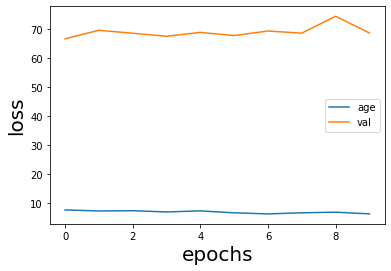

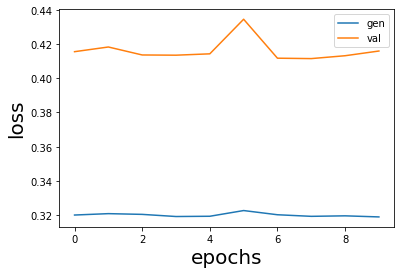

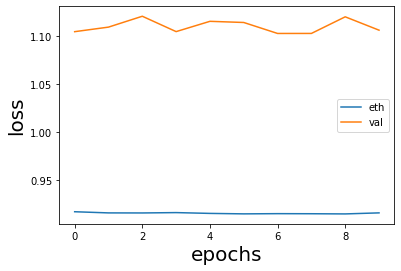

In [160]:
plot_train_val(loss_train, loss_val, mode)

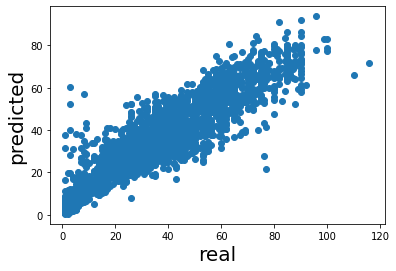

age Mean Error is 5.833930015563965
gender accuracy is 0.8962053571428571
ethnicity accuracy is 0.7901785714285714


In [161]:
class_accuracy(model, X_val, y_val, batch_size, mode)

In [164]:
model.train()
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/model.pt')
#torch.save(optimizer.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/optimizer.pt')

# Test

In [144]:
#@title test_accuracy
def test_accuracy(model, image):
  path = '/content/gdrive/MyDrive/Colab Notebooks/' + image
  im = Image.open(path)
  #im.show()
  transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  X = transform(im)[None]
  
  model.eval()
  with torch.no_grad():
    output = model(X.to(device))
  #   pred_g = torch.argmax(output[:,1:3], dim=1).item()
  #   pred_e = torch.argmax(output[:,3:], dim=1).item()
  #   age = output[:,0].item()
  # return age, pred_g, pred_e
  return output

In [145]:
#@title test_classes
def test_classes(result):
  #result = torch.squeeze(result)
  ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Hispanic']
  gender = ['Male', 'Female']
  print('age is', result[0].item())
  gen = torch.argmax(result[1:3]).item()
  print('gender is', gender[gen])
  eth = torch.argmax(result[3:]).item()
  print('ethnicity is', ethnicity[eth])

In [146]:
image = 'prof_200.jpg' 

In [162]:
result = test_accuracy(model, image)

In [163]:
print(result[0,0].cpu().numpy())
print(result[0,1:3].cpu().numpy())
print(result[0,3:].cpu().numpy())
test_classes(torch.squeeze(result))

39.99559
[9.9983299e-01 1.5896889e-04]
[1.1803160e-09 9.9999988e-01 1.2861923e-04 6.0187094e-10 1.0008578e-09]
age is 39.99559020996094
gender is Male
ethnicity is Black


# Evaluation metrics

In [ ]:
#@title conf_matrix
def conf_matrix(model, X_in, y_in, batch_size):
  model.eval()
  with torch.no_grad():
    new_size = y_in.size(0) - (y_in.size(0) % batch_size)
    pred_g = []
    pred_e = []  
    for i in range(0, new_size, batch_size):
      X = X_in[i:i+batch_size]
      y = y_in[i:i+batch_size]
      X = X.to(device)
      y = y.to(device)
      output = model(X)
        
      pred_g.extend(torch.argmax(output[:,1:3], dim=1).cpu().numpy())
      pred_e.extend(torch.argmax(output[:,3:], dim=1).cpu().numpy())
      

  
  conf_mat = confusion_matrix(y_in[:new_size,1], pred_g)
  ax = sns.heatmap(conf_mat, annot=True, cmap='Blues')
  ax.set_title('Gender Confusion Matrix\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.xaxis.set_ticklabels(['Male','Female'])
  ax.yaxis.set_ticklabels(['Male','Female'])
  plt.show()

  conf_mat = confusion_matrix(y_in[:new_size,2], pred_e)
  ax = sns.heatmap(conf_mat, annot=True, cmap='Blues')
  ax.set_title('Ethnicity Confusion Matrix\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.xaxis.set_ticklabels(['White','Black', 'Asian', 'Indian', 'Other'])
  ax.yaxis.set_ticklabels(['White','Black', 'Asian', 'Indian', 'Other'])
  plt.show()

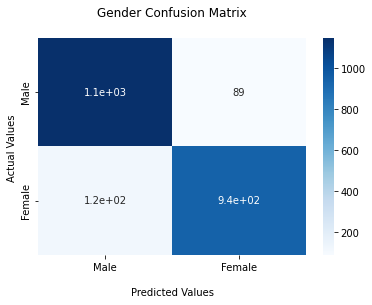

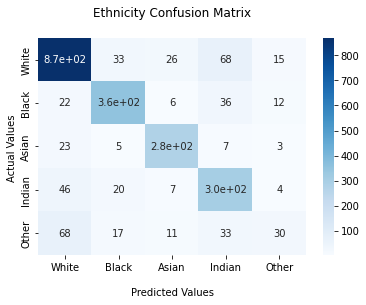

In [ ]:
conf_matrix(model, X_test, y_test, batch_size)

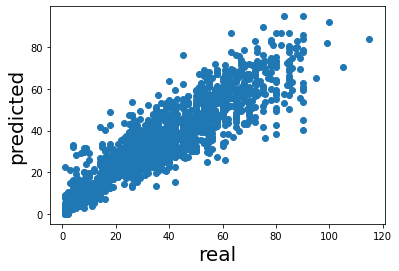

age Mean Error is 6.103487968444824
gender accuracy is 0.8993055555555556
ethnicity accuracy is 0.7899305555555556


In [ ]:
class_accuracy(model, X_test, y_test, batch_size, mode)